In [13]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, normalize
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_raw = pd.read_pickle('./features/all_data_features_17_20.pkl')
data_raw.head(2)

,cdate,content,ddate,details,forum,id,invitation,label,nonreaders,number,...,tmdate,writers,title,authors,abstract,keywords,tldr,ref_len,ref_latest,ref_years
2017_B1-Hhnslg,None,{'pdf': '/pdf/1e1d8a1884188e3ce0db825def307a25...,None,{'replyCount': 9},B1-Hhnslg,2017_B1-Hhnslg,ICLR.cc/2017/conference/-/submission,Reject,[],581,...,1481060777491,[],Prototypical Networks for Few-shot Learning,"[Jake Snell, Kevin Swersky, Richard Zemel]",A recent approach to few-shot classification c...,"[Deep learning, Transfer Learning]",We learn a metric space in which few-shot clas...,26,2016,"[2013, 2015, 2013, 2009, 2016, 2004, 2014, 201..."
2017_B1-q5Pqxl,None,{'pdf': '/pdf/78402508a0a3ebc1c9078ef8ff48dccc...,None,{'replyCount': 18},B1-q5Pqxl,2017_B1-q5Pqxl,ICLR.cc/2017/conference/-/submission,Accept,[],417,...,1489370977828,[],Machine Comprehension Using Match-LSTM and Ans...,"[Shuohang Wang, Jing Jiang]",Machine comprehension of text is an important ...,"[Natural language processing, Deep learning]",Using Match-LSTM and Answer Pointer to select ...,24,2016,"[2015, 2016, 2016, 2016, 2016, 2015, 2016, 201..."


In [3]:
print(data_raw.columns)

Index(['cdate', 'content', 'ddate', 'details', 'forum', 'id', 'invitation',
       'label', 'nonreaders', 'number', 'original', 'readers', 'referent',
       'replyto', 'signatures', 'tcdate', 'tmdate', 'writers', 'title',
       'authors', 'abstract', 'keywords', 'tldr', 'ref_len', 'ref_latest',
       'ref_years'],
      dtype='object')


# Preprocessing

#### Contains ML keywords:

In [3]:
def ml_keywords_present(abstract):
    # collected from sense2vec spacy
    ml_keywords = ["outperforms", "outperform", "novel", "machine learning", "deep learning", "neural nets", "neural networks", "rnns", "rnn", "cnn", "cnns", "attention", "lstm", "adversarial network"]
    for keyw in ml_keywords:
        if abstract.lower().find(keyw) > -1:
            return 1
    return 0

#### Contains state-of-the-art

In [4]:
def sota_present(abstract):
    if abstract.lower().find('state-of-the-art') > -1 or abstract.lower().find('state of the art') > -1:
            return 1
    return 0

#### Glove vec average:

In [5]:
embeddings_dict = {}

with open("/home/shruti/data/glove/glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
def get_glove_avg(abstract):
    glove_avg = 0
    count = 0
    
    doc = nlp(abstract)
    
    for tok in doc:
        if not tok.is_stop:
            clean_token = tok.text.lower().strip()
            if clean_token in embeddings_dict:
                count += 1
                glove_avg += embeddings_dict[clean_token]
    
    if count > 1:
        return np.mean(glove_avg/count)
    else:
        return np.mean(glove_avg)

#### Avg sentence length of abstract

In [8]:
def avg_abs_sent_length(abstract):
    avg_sent_length = 0
    
    doc = nlp(abstract)
    for s in doc.sents:
        avg_sent_length += len(s)
    
    num_sents = len(list(doc.sents))
    
    if num_sents > 0:
        return avg_sent_length/num_sents
    else:
        return avg_sent_length

#### Number of recent references (last 5 year)

In [9]:
def get_num_recent_refs(list_refs):
    count = 0
    for i in list_refs:
        if int(i) >= 2012:
            count += 1
    return count

#### Loading the new features dict

In [10]:
new_features_from_text = None
with open('./OCR_workspace/feature_dict/17_20_new_features.pkl', "rb") as f:
    new_features_from_text = pickle.load(f)

#### Loading the count of ICLR references featres dict

In [11]:
iclr_refs_count = None
with open('./OCR_workspace/feature_dict/iclr_refs_count.pkl', 'rb') as f:
    iclr_refs_count = pickle.load(f)

In [12]:
list(iclr_refs_count.items())[0:5]

[('2018_rk9kKMZ0-', 0),
 ('2018_rJ8rHkWRb', 0),
 ('2017_Syoiqwcxx', 3),
 ('2020_HkgR8erKwB', 0),
 ('2019_H1fU8iAqKX', 1)]

#### Avg. ref mention length in chars

In [13]:
def get_avg_ref_mention_length(id):
    pid = id
    if pid in new_features_from_text:
        if "avg_ref_mention" in new_features_from_text[pid]:
            return new_features_from_text[pid]["avg_ref_mention"]
        else:
            print("Missing avg_ref_mention for: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Number of sections

In [14]:
def get_num_sections(id):
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "num_sections" in new_features_from_text[pid]:
            return new_features_from_text[pid]["num_sections"]
        else:
            return 4
    else:
        print("Missing pid for ", pid)
        return 4

#### Contains appendix

In [15]:
def contains_appendix(id):
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "contains_appendix" in new_features_from_text[pid]:
            return new_features_from_text[pid]["contains_appendix"]
        else:
            print("Key contains_appendix not present: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Count of tables, equations, figures

In [16]:
def get_count_of_fig_table_eqn(id):
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and "eqn_ref_count" in new_features_from_text[pid] and "fig_ref_count" in new_features_from_text[pid]:
            total_count = new_features_from_text[pid]["table_ref_count"] + new_features_from_text[pid]["fig_ref_count"] + new_features_from_text[pid]["eqn_ref_count"]
            return total_count
        else:
            print("Keys  count_of_fig_table_eqn keys missing for ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### contains table

In [17]:
def contains_table(id):
    pid = id
    
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["table_ref_count"] and new_features_from_text[pid]["table_ref_count"]>0:
            return 1
    return 0

#### Contains equation(s)

In [18]:
def contains_equation(id):
    pid = id
    
    if pid in new_features_from_text:
        if "eqn_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["eqn_ref_count"] and new_features_from_text[pid]["eqn_ref_count"]>0:
            return 1
    return 0

#### Contains figure(s)

In [19]:
def contains_figure(id):
    pid = id
    
    if pid in new_features_from_text:
        if "fig_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["fig_ref_count"] and new_features_from_text[pid]["fig_ref_count"]>0:
            return 1
    return 0

#### Count of ICLR references

In [20]:
def get_iclr_refs_count(id):
    pid = id
    if pid in iclr_refs_count:
        return iclr_refs_count[pid]
    return 0

### Feature Matrix Creation

In [21]:
data = pd.DataFrame()
data_raw = data_raw[data_raw['label']!='Invite']
data['id'] = data_raw['id']
data['n_authors'] = data_raw['authors'].apply(len)
data['len_char_title'] = data_raw['title'].apply(len)
data['len_word_title'] = data_raw['title'].apply(lambda x: len(re.split(':|\s',x)))
data['len_char_abstract'] = data_raw['abstract'].apply(len)
data['len_word_abstract'] = data_raw['abstract'].apply(lambda x: len(re.split(':|\s',x)))
# data['replyCount'] = data_raw['replyCount']
data['n_keywords'] = data_raw['keywords'].apply(len)
data['ref_len'] = data_raw['ref_len']
data['ref_latest'] = data_raw['ref_latest']
data['num_recent_refs'] = data_raw['ref_years'].apply(get_num_recent_refs)
data['contains_ml_keyword'] = data_raw['abstract'].apply(ml_keywords_present)
data['avg_sent_len'] = data_raw['abstract'].apply(avg_abs_sent_length)
data['abs_glove_avg'] = data_raw['abstract'].apply(get_glove_avg)
data['contains_sota'] = data_raw['abstract'].apply(sota_present)
data['avg_ref_length'] = data_raw['id'].apply(get_avg_ref_mention_length)
data['num_sections'] = data_raw['id'].apply(get_num_sections)
data['contains_appendix'] = data_raw['id'].apply(contains_appendix)
data['fig_tab_eqn_count'] = data_raw['id'].apply(get_count_of_fig_table_eqn)
data['contains_table'] = data_raw['id'].apply(contains_table)
data['contains_figure'] = data_raw['id'].apply(contains_figure)
data['contains_equation'] = data_raw['id'].apply(contains_equation)
data['iclr_references'] = data_raw['id'].apply(get_iclr_refs_count)


data['label'] = data_raw['label']

Missing pid for  2018_H1cKvl-Rb
Missing pid for  2018_rJBwoM-Cb
Missing pid for  2019_S1giVsRcYm
Missing pid for  2020_SkeHuCVFDr
Missing pid for  2018_H1cKvl-Rb
Missing pid for  2018_rJBwoM-Cb
Missing pid for  2019_S1giVsRcYm
Missing pid for  2020_SkeHuCVFDr
Key contains_appendix not present:  2017_r1Usiwcex
Key contains_appendix not present:  2018_B1p461b0W
Key contains_appendix not present:  2018_By-7dz-AZ
Key contains_appendix not present:  2018_BywyFQlAW
Missing pid for  2018_H1cKvl-Rb
Key contains_appendix not present:  2018_HktXuGb0-
Missing pid for  2018_rJBwoM-Cb
Key contains_appendix not present:  2019_BJlc6iA5YX
Key contains_appendix not present:  2019_Byg0DsCqYQ
Key contains_appendix not present:  2019_Hyed4i05KX
Missing pid for  2019_S1giVsRcYm
Key contains_appendix not present:  2020_BJlxdCVKDB
Key contains_appendix not present:  2020_H1gx3kSKPS
Key contains_appendix not present:  2020_H1lQJ1HYwS
Key contains_appendix not present:  2020_HJgEMpVFwB
Missing pid for  2020_Sk

In [22]:
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,contains_sota,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
2017_B1-Hhnslg,2017_B1-Hhnslg,3,43,5,1062,156,2,26,2016,19,...,1,30,11,0,6,1,1,1,1,Reject
2017_B1-q5Pqxl,2017_B1-q5Pqxl,2,57,7,1145,173,2,24,2016,23,...,0,60,17,1,13,1,1,0,3,Accept


In [23]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,contains_sota,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label


In [24]:
data['label'].unique()

array(['Reject', 'Accept'], dtype=object)

### Save feature dict for future experiments

In [112]:
data.to_pickle('./features/all_data_features_csv_17_20_new.pkl')

In [111]:
data.shape

(4897, 24)

### Read data directly

In [2]:
data = pd.read_pickle('./features/all_data_features_csv_17_20_new.pkl')
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label,ref_latest_depth
2017_HJIY0E9ge,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,250,13,0,25,1,1,1,0,Reject,2
2017_BkdpaH9ll,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,48,14,0,10,1,1,1,2,Reject,2


In [3]:
print(data.columns, len(data.columns))

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
       'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'ref_latest_depth'],
      dtype='object') 24


### Running the Models

In [9]:
# shuffle the data
data = data.sample(n=len(data), random_state=42)

In [4]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
                         out_file=dot_data, 
                         class_names=['Accept','Reject'], # the target names.
                         feature_names=X.columns, # the feature names.
                         filled=True, # Whether to fill in the boxes with colours.
                         rounded=True, # Whether to round the corners of the boxes.
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

#### All Models

In [5]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=5),
            'LogisticR':LogisticRegression(max_iter=1000),
            'LogisticLassoR':LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=1000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

#### A. Without Normalization

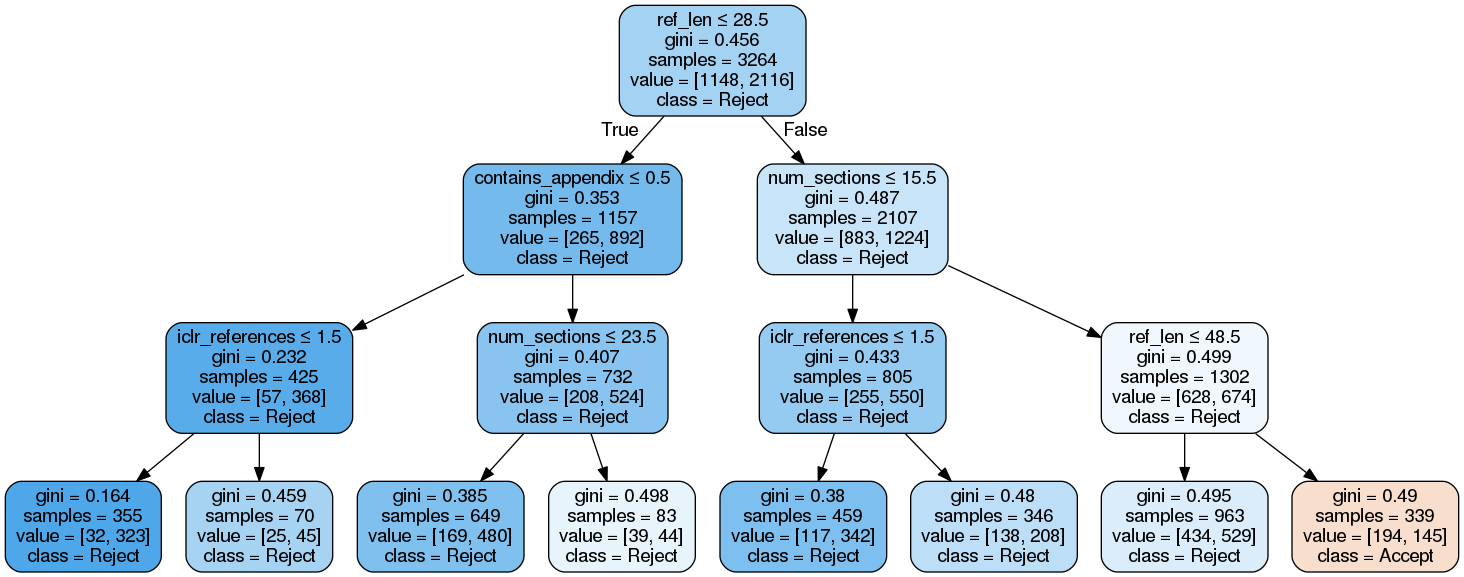

In [32]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id','label'])
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [33]:
# Model results with all the new features without normalization
model_results

,Accuracy,CVresults
RandomForest,0.650192,"{'fit_time': [0.13768959045410156, 0.068237066..."
SVC,0.648152,"{'fit_time': [0.9058036804199219, 0.9056830406..."
DecisionTree,0.656932,"{'fit_time': [0.016857147216796875, 0.01682019..."
KNN,0.602818,"{'fit_time': [0.06288623809814453, 0.010370254..."
LogisticR,0.656322,"{'fit_time': [0.07733821868896484, 0.137030124..."
LogisticLassoR,0.658772,"{'fit_time': [0.3037564754486084, 0.5813546180..."
RidgeClf,0.658977,"{'fit_time': [0.15505385398864746, 0.051584243..."
GaussNB,0.635493,"{'fit_time': [0.020200014114379883, 0.01129031..."
GaussianProcessClf,0.535021,"{'fit_time': [11.783643245697021, 11.575909614..."
NeuralNet,0.642433,"{'fit_time': [2.0210280418395996, 3.4236779212..."


#### B. With Feature Normalization

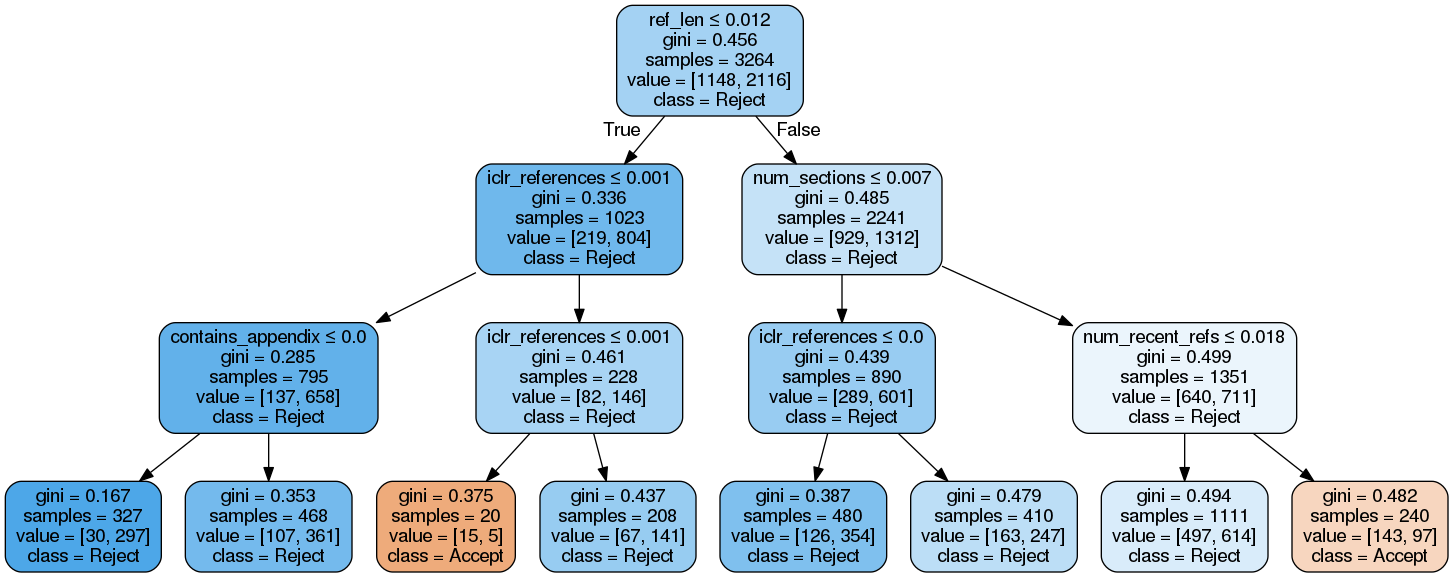

In [34]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label'])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [35]:
# Model results with all the new features normalized
model_results

,Accuracy,CVresults
RandomForest,0.647131,"{'fit_time': [0.10721397399902344, 0.104953289..."
SVC,0.648152,"{'fit_time': [0.723097562789917, 0.76182937622..."
DecisionTree,0.650194,"{'fit_time': [0.029883384704589844, 0.02969646..."
KNN,0.603838,"{'fit_time': [0.008907556533813477, 0.00763273..."
LogisticR,0.648152,"{'fit_time': [0.013231277465820312, 0.03331446..."
LogisticLassoR,0.647131,"{'fit_time': [0.11252951622009277, 0.246364593..."
RidgeClf,0.647948,"{'fit_time': [0.07208609580993652, 0.034061193..."
GaussNB,0.494603,"{'fit_time': [0.016550064086914062, 0.01595687..."
GaussianProcessClf,0.653667,"{'fit_time': [103.16888380050659, 91.387792348..."
NeuralNet,0.647948,"{'fit_time': [5.900876998901367, 5.85564661026..."


In [47]:
model_results["CVresults"].iloc[8]

{'fit_time': array([103.1688838 ,  91.38779235, 100.46414757]),
 'score_time': array([0.34182882, 0.34286499, 0.33897281]),
 'test_score': array([0.64788732, 0.65073529, 0.66237745])}

#### C. 80-20 Train-Test Split with normalized features

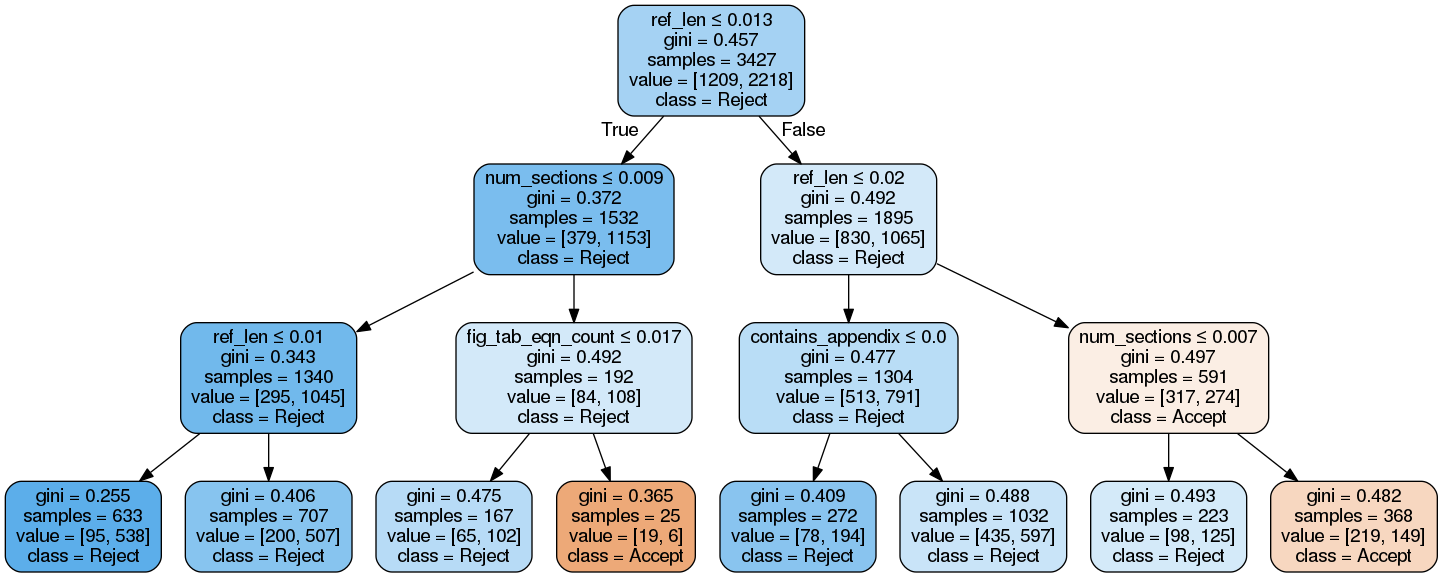

In [62]:
X = data.drop(columns=['id', 'label'])
y = data['label']
X_normalized = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.30, random_state=42)

results_on_test = pd.DataFrame()
results_on_test['Accuracy'] = None

for clf_name,clf in clf_dict.items():
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    results_on_test.loc[clf_name, 'Accuracy'] = test_score
    
    if clf_name == 'DecisionTree':
        display(plot([clf]))

In [63]:
# Model results on train-test with feature normalization
results_on_test

,Accuracy
RandomForest,0.648299
SVC,0.65034
DecisionTree,0.653061
KNN,0.62585
LogisticR,0.65034
LogisticLassoR,0.65034
RidgeClf,0.65034
GaussNB,0.42381
GaussianProcessClf,0.658503
NeuralNet,0.65034


In [9]:
data.columns

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
       'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label'],
      dtype='object')

#### D. With normalization and less features 

In [113]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

KeyboardInterrupt: 

In [12]:
model_results

,Accuracy,CVresults
GaussNB,0.435158,"{'score_time': [0.006419658660888672, 0.003385..."
SVC,0.648152,"{'score_time': [0.12853145599365234, 0.1687719..."
LogisticR,0.648356,"{'score_time': [0.009512186050415039, 0.010195..."
NeuralNet,0.648356,"{'score_time': [0.015566825866699219, 0.016050..."
GaussianProcessClf,0.651215,"{'score_time': [0.2685539722442627, 0.26849150..."
LogisticLassoR,0.648152,"{'score_time': [0.009412527084350586, 0.008833..."
DecisionTree,0.641413,"{'score_time': [0.00923466682434082, 0.0024526..."
KNN,0.610163,"{'score_time': [0.12597370147705078, 0.0682134..."
RandomForest,0.645087,"{'score_time': [0.005403757095336914, 0.004270..."
RidgeClf,0.648152,"{'score_time': [0.009746313095092773, 0.009650..."


In [14]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == "DecisionTree":
#         display(plot(clf))
print(model_results)

                    Accuracy  \
GaussNB             0.491082   
SVC                 0.648152   
LogisticR           0.648152   
NeuralNet           0.648152   
GaussianProcessClf  0.656118   
LogisticLassoR       0.64754   
DecisionTree        0.636102   
KNN                 0.600976   
RandomForest        0.633444   
RidgeClf            0.647948   

                                                            CVresults  
GaussNB             {'score_time': [0.0029573440551757812, 0.00497...  
SVC                 {'score_time': [0.13742899894714355, 0.1753044...  
LogisticR           {'score_time': [0.009365320205688477, 0.009972...  
NeuralNet           {'score_time': [0.015427350997924805, 0.014686...  
GaussianProcessClf  {'score_time': [0.33835577964782715, 0.2841620...  
LogisticLassoR      {'score_time': [0.003923892974853516, 0.008049...  
DecisionTree        {'score_time': [0.009068727493286133, 0.003330...  
KNN                 {'score_time': [0.06799578666687012, 0.0606956...  

In [15]:
model_results

,Accuracy,CVresults
GaussNB,0.491082,"{'score_time': [0.0029573440551757812, 0.00497..."
SVC,0.648152,"{'score_time': [0.13742899894714355, 0.1753044..."
LogisticR,0.648152,"{'score_time': [0.009365320205688477, 0.009972..."
NeuralNet,0.648152,"{'score_time': [0.015427350997924805, 0.014686..."
GaussianProcessClf,0.656118,"{'score_time': [0.33835577964782715, 0.2841620..."
LogisticLassoR,0.64754,"{'score_time': [0.003923892974853516, 0.008049..."
DecisionTree,0.636102,"{'score_time': [0.009068727493286133, 0.003330..."
KNN,0.600976,"{'score_time': [0.06799578666687012, 0.0606956..."
RandomForest,0.633444,"{'score_time': [0.004885196685791016, 0.004877..."
RidgeClf,0.647948,"{'score_time': [0.0067212581634521484, 0.00700..."


# Proper normalization

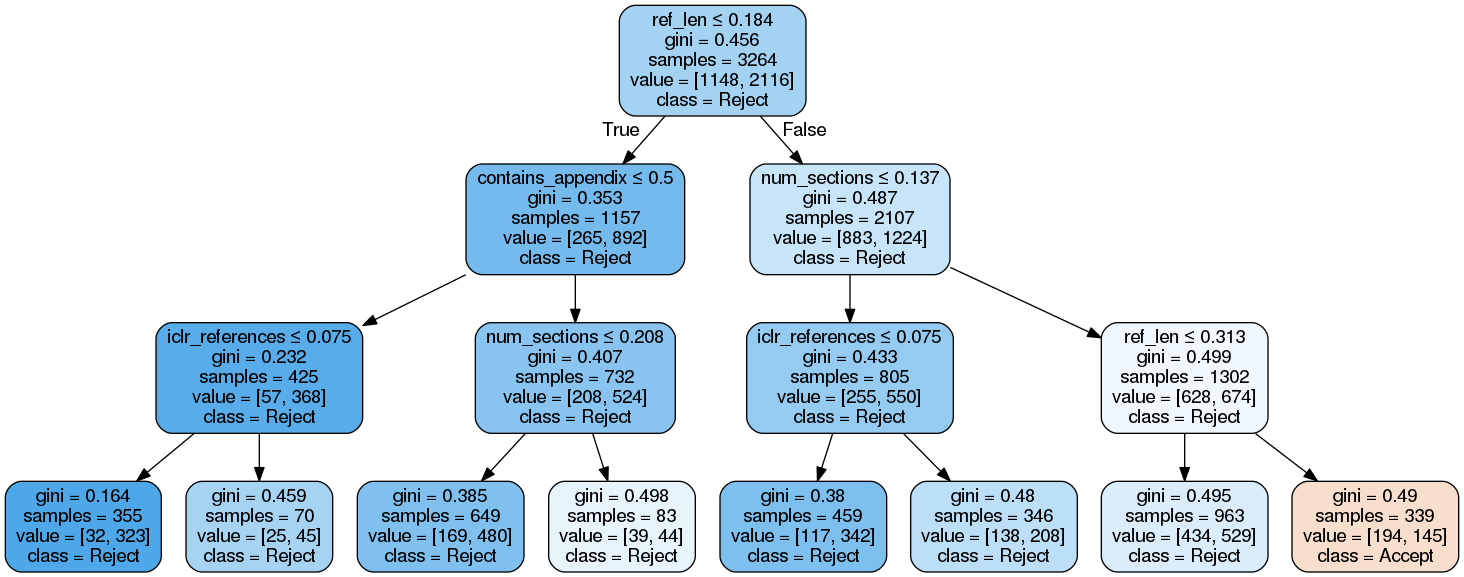

In [114]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = X / X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))
# print(model_results)

In [110]:
model_results

,Accuracy,CVresults
KNN,0.614459,"{'score_time': [0.11646866798400879, 0.1075627..."
LogisticLassoR,0.657752,"{'score_time': [0.006931304931640625, 0.007174..."
GaussianProcessClf,0.652237,"{'score_time': [0.36252284049987793, 0.2687337..."
DecisionTree,0.656932,"{'score_time': [0.005154132843017578, 0.005113..."
SVC,0.648152,"{'score_time': [0.25811290740966797, 0.2584536..."
NeuralNet,0.658567,"{'score_time': [0.014550447463989258, 0.014193..."
RandomForest,0.645497,"{'score_time': [0.0058901309967041016, 0.00567..."
RidgeClf,0.658977,"{'score_time': [0.0065152645111083984, 0.00729..."
LogisticR,0.659385,"{'score_time': [0.007173776626586914, 0.008253..."
GaussNB,0.636106,"{'score_time': [0.010021209716796875, 0.010400..."


In [106]:
data["ref_latest_depth"] = 2020 - data["ref_latest"]

In [7]:
print(len(data.columns), data.columns)

24 Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
       'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'ref_latest_depth'],
      dtype='object')


In [ ]:
# final baseline result on iclr5k dataset

In [11]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', 'ref_latest_depth'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
#     X_normalized = normalize(X)
    X_normalized = X / X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == "DecisionTree":
#         display(plot(clf))
# print(model_results)

In [12]:
model_results

,Accuracy,CVresults
RandomForest,0.657749,"{'fit_time': [0.04215884208679199, 0.041407585..."
LogisticR,0.660202,"{'fit_time': [0.024332761764526367, 0.05214953..."
SVC,0.648152,"{'fit_time': [0.8794667720794678, 0.8536612987..."
GaussNB,0.636106,"{'fit_time': [0.007638692855834961, 0.00751495..."
DecisionTree,0.656932,"{'fit_time': [0.01654338836669922, 0.016608715..."
KNN,0.614867,"{'fit_time': [0.011548519134521484, 0.01152539..."
GaussianProcessClf,0.652442,"{'fit_time': [65.56645941734314, 66.2566039562..."
RidgeClf,0.658977,"{'fit_time': [0.026577472686767578, 0.03730297..."
LogisticLassoR,0.657752,"{'fit_time': [0.34461069107055664, 0.371365547..."
NeuralNet,0.659793,"{'fit_time': [4.837802171707153, 3.48787713050..."


In [10]:
#FINAL RESULTS WITH WRONG NORMALIZATION
model_results

,Accuracy,CVresults
RandomForest,0.655707,"{'fit_time': [0.06560206413269043, 0.065268993..."
LogisticR,0.648152,"{'fit_time': [0.055289506912231445, 0.03221607..."
SVC,0.648152,"{'fit_time': [0.7638711929321289, 0.7164280414..."
GaussNB,0.494603,"{'fit_time': [0.006494998931884766, 0.00685715..."
DecisionTree,0.650194,"{'fit_time': [0.02968144416809082, 0.029636621..."
KNN,0.603838,"{'fit_time': [0.008607864379882812, 0.00754141..."
GaussianProcessClf,0.653667,"{'fit_time': [104.63979530334473, 93.176122903..."
RidgeClf,0.647948,"{'fit_time': [0.08350491523742676, 0.038865089..."
LogisticLassoR,0.647131,"{'fit_time': [0.12562036514282227, 0.226786613..."
NeuralNet,0.648152,"{'fit_time': [5.939497709274292, 5.80300927162..."


# Error Analysis

In [86]:
X = data.drop(columns=['id', 'label'])#
y = data['label']
X_normalized = X / X.max(axis=0)#normalize(X)

# clf = SVC(kernel='rbf').fit(X_normalized, y)
# clf = LogisticRegression(max_iter=5000).fit(X_normalized, y)
# clf = RidgeClassifier(max_iter=5000).fit(X_normalized, y)
clf =  LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear').fit(X_normalized, y)
# clf = GaussianProcessClassifier(kernel=kls.RBF()).fit(X_normalized, y)
predictions = clf.predict(X_normalized)

results = cross_validate(clf, X_normalized, y, return_estimator=True)
results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
model_results = [accuracy, results]


In [87]:
model_results

[0.657752157303011,
 {'fit_time': array([0.27473688, 0.23668408, 0.20378017]),
  'score_time': array([0.00540662, 0.00533032, 0.00696254]),
  'test_score': array([0.64543784, 0.66237745, 0.66544118])}]

In [ ]:
'DecisionTree':DecisionTreeClassifier(max_depth=3),
'RandomForest':RandomForestClassifier(max_depth=10),
'LogisticR':LogisticRegression(max_iter=5000),
'LogisticLassoR':LogisticRegression(max_iter=5000, penalty='l1',solver='liblinear'),
'RidgeClf':RidgeClassifier(max_iter=5000),
'SVC':SVC(kernel='rbf'),
'GaussNB':GaussianNB(),
'NeuralNet':MLPClassifier((50),activation='logistic'),
'KNN':KNeighborsClassifier(n_neighbors=10),
'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())       

In [98]:
print("Id\t Pred \t True")
count = 0
data_ids = data["id"]

error_details = pd.DataFrame(columns = ["paperId", "pred_label", "true_label"])
feat_values = pd.DataFrame(columns = ["paperId"] + [fid for fid in X.columns])

for idx, (prediction, label) in enumerate(zip(predictions, y)):
    if prediction != label:
#         print(data_ids.iloc[idx], prediction, label,  X_normalized[idx,:])
        error_details.loc[count] = [data_ids.iloc[idx], prediction, label]
        feat_values.loc[count] =  np.concatenate(([data_ids.iloc[idx]], X_normalized.iloc[idx]))
#         error_details.append({"paperId": data_ids.iloc[idx], "pred_label": prediction, "true_label": label, 
#                               "feature_values": X_normalized[idx,:]}, ignore_index=True)
        count += 1
#         if count > 10:
#             break

Id	 Pred 	 True


In [104]:
clf.coef_

array([[-1.21898832e+00,  4.65886846e-01,  0.00000000e+00,
        -2.71851625e-02,  0.00000000e+00,  4.45034666e-02,
        -2.67917323e+00,  9.74609601e-01, -2.81756829e-01,
         7.51144750e-02, -4.18387416e-01, -9.04001669e-01,
        -1.97011021e-01,  7.89325466e-01, -2.32446798e+00,
        -5.44600973e-01, -1.25947060e+00,  1.60538819e-01,
        -1.43151833e-03, -2.58180040e-02, -1.51202230e+00]])

In [69]:
error_details.to_csv("error_labels.csv")

In [99]:
feat_values.head()

,paperId,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,abs_glove_avg,contains_sota,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references
0,2020_rkecl1rtwB,0.11764705882352941,0.25316455696202533,0.2608695652173913,0.33057256031688875,0.3316831683168317,0.14285714285714285,0.1032258064516129,0.6962068965517242,0.125,...,0.5157133441561677,0.0,0.02487864077669903,0.21238938053097345,1.0,0.09009009009009009,1.0,1.0,1.0,0.15
1,2019_HkgYmhR9KX,0.29411764705882354,0.47468354430379744,0.4782608695652174,0.6341375585163845,0.6584158415841584,0.19047619047619047,0.23225806451612904,0.6962068965517242,0.25,...,0.40529514932169514,0.0,0.02912621359223301,0.1415929203539823,1.0,0.11711711711711711,1.0,1.0,1.0,0.0
2,2019_Hke4l2AcKQ,0.17647058823529413,0.4810126582278481,0.34782608695652173,0.33849477853799065,0.30198019801980197,0.14285714285714285,0.3032258064516129,0.6958620689655173,0.3854166666666667,...,0.49001951784225517,0.0,0.022451456310679612,0.19469026548672566,1.0,0.07207207207207207,1.0,1.0,0.0,0.2
3,2018_HkL7n1-0b,0.23529411764705882,0.15822784810126583,0.08695652173913043,0.2657544112351458,0.2599009900990099,0.23809523809523808,0.1935483870967742,0.6955172413793104,0.2916666666666667,...,0.6966385832892211,0.0,0.19599514563106796,0.10619469026548672,0.0,0.02252252252252252,1.0,1.0,1.0,0.2
4,2019_ryeYHi0ctQ,0.23529411764705882,0.26582278481012656,0.30434782608695654,0.4162765574360821,0.41089108910891087,0.19047619047619047,0.2645161290322581,0.6958620689655173,0.3645833333333333,...,0.4885571201417991,1.0,0.2366504854368932,0.12389380530973451,0.0,0.0945945945945946,1.0,1.0,0.0,0.05


In [100]:
feat_values.to_csv("feat_for_errors.csv")

In [74]:
X.shape

(4897, 21)

In [75]:
x_normed = X / X.max(axis=0)

In [78]:
x_normed.shape, x_normed.columns

((4897, 21),
 Index(['n_authors', 'len_char_title', 'len_word_title', 'len_char_abstract',
        'len_word_abstract', 'n_keywords', 'ref_len', 'ref_latest',
        'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
        'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
        'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
        'contains_figure', 'contains_equation', 'iclr_references'],
       dtype='object'))

In [93]:
idx

2

In [95]:
X_normalized

,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,contains_ml_keyword,...,abs_glove_avg,contains_sota,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references
2017_HJIY0E9ge,0.176471,0.443038,0.521739,0.296363,0.299505,0.047619,0.141935,0.695172,0.125000,1.0,...,0.668180,0.0,0.151699,0.115044,0.0,0.112613,1.0,1.0,1.0,0.00
2017_BkdpaH9ll,0.294118,0.259494,0.217391,0.387468,0.368812,0.095238,0.193548,0.695172,0.250000,1.0,...,0.466171,1.0,0.029126,0.123894,0.0,0.045045,1.0,1.0,1.0,0.10
2020_rkecl1rtwB,0.117647,0.253165,0.260870,0.330573,0.331683,0.142857,0.103226,0.696207,0.125000,1.0,...,0.515713,0.0,0.024879,0.212389,1.0,0.090090,1.0,1.0,1.0,0.15
2019_HkgYmhR9KX,0.294118,0.474684,0.478261,0.634138,0.658416,0.190476,0.232258,0.696207,0.250000,1.0,...,0.405295,0.0,0.029126,0.141593,1.0,0.117117,1.0,1.0,1.0,0.00
2020_ryxW804FPH,0.176471,0.430380,0.347826,0.270076,0.277228,0.190476,0.200000,0.696207,0.208333,1.0,...,0.431888,1.0,0.020024,0.088496,1.0,0.076577,1.0,1.0,1.0,0.10
2019_Hke4l2AcKQ,0.176471,0.481013,0.347826,0.338495,0.301980,0.142857,0.303226,0.695862,0.385417,1.0,...,0.490020,0.0,0.022451,0.194690,1.0,0.072072,1.0,1.0,0.0,0.20
2018_HkL7n1-0b,0.235294,0.158228,0.086957,0.265754,0.259901,0.238095,0.193548,0.695517,0.291667,0.0,...,0.696639,0.0,0.195995,0.106195,0.0,0.022523,1.0,1.0,1.0,0.20
2020_SklgTkBKDr,0.058824,0.246835,0.173913,0.243428,0.240099,0.000000,0.135484,0.696207,0.083333,0.0,...,0.475347,0.0,0.097087,0.176991,0.0,0.058559,1.0,1.0,0.0,0.05
2017_Sk8J83oee,0.235294,0.240506,0.130435,0.360821,0.358911,0.047619,0.122581,0.695172,0.145833,1.0,...,0.552079,0.0,0.024272,0.132743,1.0,0.162162,1.0,1.0,1.0,0.00
2019_ryeYHi0ctQ,0.235294,0.265823,0.304348,0.416277,0.410891,0.190476,0.264516,0.695862,0.364583,1.0,...,0.488557,1.0,0.236650,0.123894,0.0,0.094595,1.0,1.0,0.0,0.05


In [97]:
X_normalized.iloc[2]

n_authors              0.117647
len_char_title         0.253165
len_word_title         0.260870
len_char_abstract      0.330573
len_word_abstract      0.331683
n_keywords             0.142857
ref_len                0.103226
ref_latest             0.696207
num_recent_refs        0.125000
contains_ml_keyword    1.000000
avg_sent_len           0.417344
abs_glove_avg          0.515713
contains_sota          0.000000
avg_ref_length         0.024879
num_sections           0.212389
contains_appendix      1.000000
fig_tab_eqn_count      0.090090
contains_table         1.000000
contains_figure        1.000000
contains_equation      1.000000
iclr_references        0.150000
Name: 2020_rkecl1rtwB, dtype: float64

In [ ]:
X = data.drop(columns=['id', 'label', 'ref_latest'])
X_normalized = X / X.max(axis=0)